In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from curiosity import m_passthrough_action

In [36]:
def matrix_dist(A, B):
    return np.linalg.norm((A - B).flatten(), ord=1)

In [145]:
# "model of the environment"
A = np.array([
    [1,0,1,0], # state and action, gives s_1
    [0,1,0,1],
])

# transform for the state
Q1 = np.random.randn(2, 2)

# transform for state+action
Q = np.eye(4)
Q[:2, :2] = Q1

# number of data pts
N = 500

# states
xs = np.random.randn(4, N)

# next states
ys = A @ xs

xs_e = Q @ xs
ys_e = Q1 @ ys

# states
xs = xs.T
ys = ys.T

# observations
xs_e = xs_e.T
ys_e = ys_e.T

In [146]:
# checking that the model works correctly
assert np.allclose(A @ (np.linalg.inv(Q) @ xs_e[0]), ys[0])
assert np.allclose(xs_e[0][2:], xs[0][2:])

5000/5000 [==============================] - 0s 23us/sample - loss: 2.0503e-14
2.050331335647689e-14
[<tf.Variable 'sequential_50/dense_52/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 1.0000000e+00,  4.3017614e-08],
       [-2.4425237e-08,  1.0000000e+00],
       [ 1.0000000e+00, -2.7852550e-08],
       [-3.4796134e-08,  1.0000001e+00]], dtype=float32)>, <tf.Variable 'sequential_50/dense_52/bias:0' shape=(2,) dtype=float32, numpy=array([-6.061311e-08, -8.156938e-08], dtype=float32)>]
2.4930082531682274e-07


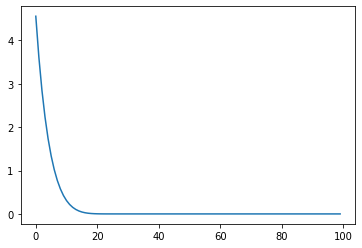

In [140]:
# checking that data is correctly generated
m = tf.keras.Sequential([tf.keras.layers.Dense(2)])
m.compile('adam', 'mse')
h = m.fit(xs, ys, epochs=100, verbose=0)
plt.plot(h.history['loss'])
print(m.evaluate(xs, ys))
print(m.weights)
print(matrix_dist(m.weights[0].numpy().T, A))

In [189]:
l1coeff = 1e-1
l2coeff = 0
sparsity = 0.5

pruning_params = {
        'pruning_schedule': pruning_sched.ConstantSparsity(sparsity, 0),
        'block_size': (1, 1),
        'block_pooling_type': 'AVG'
    }


decoder = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                         kernel_initializer='random_normal'),
])

# maps observations to features
model = tf.keras.Sequential([
    m_passthrough_action(decoder, 2, 2),
    tf.keras.Input(shape=(4,)),
    prune.prune_low_magnitude(
        tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_regularizer=tf.keras.regularizers.l1(l1coeff),
                             kernel_initializer='random_normal'),
        **pruning_params
    )
])

model.compile('sgd', 'mae')

model()

In [190]:
losses = []
distances = []
for _ in tqdm(range(200)):
    ys_e_d = decoder(ys_e)
    h = model.fit(xs_e, ys_e_d, epochs=1, verbose=0, callbacks=[pruning_callbacks.UpdatePruningStep()])
    ys_e_d = decoder(ys_e)
    #plt.plot(h.history['loss'])
    loss = model.evaluate(xs_e, ys_e_d, verbose=0)
    #print(model.weights)
    #print("DIST", matrix_dist(model.weights[-1].numpy().T, A))
    DE = decoder.weights[0].numpy().T @ Q1
    DE = DE / DE[0, 0]
    dist = matrix_dist(DE, np.eye(2))
    losses.append(loss)
    distances.append(dist)

  0%|          | 0/200 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 200/200 [00:14<00:00, 13.87it/s]


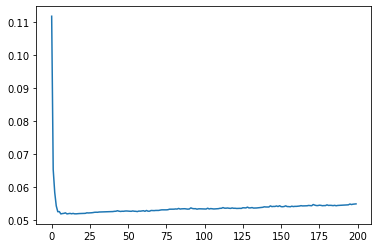

In [191]:
plt.plot(losses)

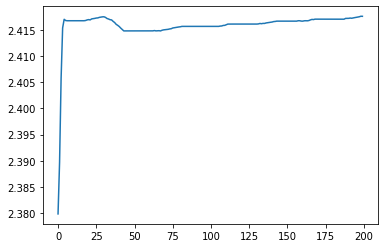

In [192]:
plt.plot(distances)

In [188]:
DE = decoder.weights[0].numpy().T @ Q1
DE = DE / DE[0, 0]
DE

array([[  1.        ,   0.74373555],
       [ -8.55591696, -10.8578655 ]])